In [192]:
# Bismilah 
# Fréquence trimestrielle
# Serie positive
# Pas de dates fournies => on creer un index temporelle artificiel

# on ne méllange jamais la serie 



In [193]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sns
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


data = pd.read_csv("data/Quarterly-train.csv")

Le dataset M4 est fourni en format wide : chaque colonne correspond à une série temporelle distincte. L’analyse est réalisée sur une seule série (V1), conformément aux recommandations du cours.

Une ligne = un instant t

Une colonne = l’évolution dans le temps


Une série temporelle est une suite de valeurs d’une même variable observée à différents instants.

## 1-Preparation de données

In [194]:
data_clean = data.melt(id_vars='V1', var_name='V', value_name='VALUE')

data_clean['TIME'] = data_clean['V'].str[1:].astype(int) -1

data_clean = data_clean.rename(columns={'V1': 'ID'})

data_clean = data_clean.dropna(subset=['VALUE'])

data_clean = data_clean.sort_values(['ID', 'TIME'])

data_clean['TIME'] = data_clean.groupby('ID').cumcount() + 1

data_clean = data_clean[['ID', 'TIME', 'VALUE']].reset_index(drop=True)

print(data_clean.head(10))


   ID  TIME        VALUE
0  Q1     1  7407.412314
1  Q1     2  7528.566074
2  Q1     3  7374.709225
3  Q1     4  7395.514848
4  Q1     5  7654.007989
5  Q1     6  7686.847835
6  Q1     7  7578.190743
7  Q1     8  7904.376716
8  Q1     9  7744.049254
9  Q1    10  7889.909013


In [195]:
first_quarterly = data_clean[data_clean['ID'] == data_clean['ID'].unique()[0]]
serie = first_quarterly["VALUE"]

In [196]:
serie.head()

0    7407.412314
1    7528.566074
2    7374.709225
3    7395.514848
4    7654.007989
Name: VALUE, dtype: float64

In [197]:
serie.info()

<class 'pandas.core.series.Series'>
Index: 25 entries, 0 to 24
Series name: VALUE
Non-Null Count  Dtype  
--------------  -----  
25 non-null     float64
dtypes: float64(1)
memory usage: 400.0 bytes


In [198]:
serie.dtype

dtype('float64')

## 2 Creation de l'index trimestriel

In [199]:
serie.index = pd.period_range(
    start = "2000Q1",
    periods = len(serie),
    freq = "Q"
)

In [200]:
# Créer l’index temporel (trimestriel) car pour l'instant la serie à un index numerique 

serie.head()

2000Q1    7407.412314
2000Q2    7528.566074
2000Q3    7374.709225
2000Q4    7395.514848
2001Q1    7654.007989
Freq: Q-DEC, Name: VALUE, dtype: float64

In [201]:
serie.index

PeriodIndex(['2000Q1', '2000Q2', '2000Q3', '2000Q4', '2001Q1', '2001Q2',
             '2001Q3', '2001Q4', '2002Q1', '2002Q2', '2002Q3', '2002Q4',
             '2003Q1', '2003Q2', '2003Q3', '2003Q4', '2004Q1', '2004Q2',
             '2004Q3', '2004Q4', '2005Q1', '2005Q2', '2005Q3', '2005Q4',
             '2006Q1'],
            dtype='period[Q-DEC]')

In [202]:
serie.shape

(25,)

In [203]:
serie.head(10)

2000Q1    7407.412314
2000Q2    7528.566074
2000Q3    7374.709225
2000Q4    7395.514848
2001Q1    7654.007989
2001Q2    7686.847835
2001Q3    7578.190743
2001Q4    7904.376716
2002Q1    7744.049254
2002Q2    7889.909013
Freq: Q-DEC, Name: VALUE, dtype: float64

## 3-visualisation de la serie 

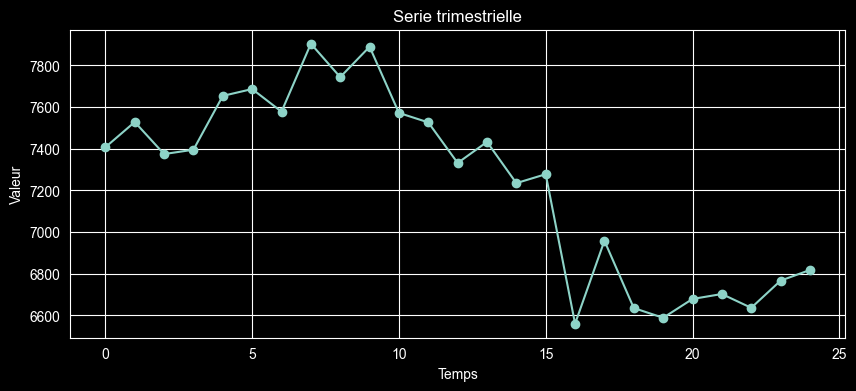

In [204]:
# visualisation de la serie 

plt.figure(figsize=(10,4))
plt.plot(serie.values, marker='o')
plt.title("Serie trimestrielle")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()

La série ne présente pas de tendance ni de saisonnalité trimestrielle clairement identifiables, mais une forte variabilité et des fluctuations irrégulières.

In [205]:
serie.head()

2000Q1    7407.412314
2000Q2    7528.566074
2000Q3    7374.709225
2000Q4    7395.514848
2001Q1    7654.007989
Freq: Q-DEC, Name: VALUE, dtype: float64

In [206]:
serie.dtype

dtype('float64')

## 4- Decomposition saisonière


<Figure size 1200x800 with 0 Axes>

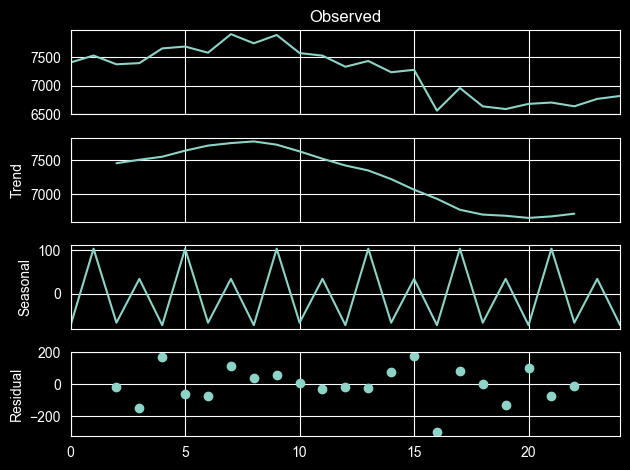

In [207]:
seasons = seasonal_decompose(serie.values, model='additive', period=4)

plt.figure(figsize=(12, 8))
seasons.plot()
plt.show()

## 4-Test de stationnarité (ADF)

In [208]:
from statsmodels.tsa.stattools import adfuller

# Est-ce que la série est stationnaire ou non ?

result = adfuller(serie)

# H₀ : la série n’est pas stationnaire

# H₁ : la série est stationnaire

In [209]:
print("ADF Statistic :", result[0])
print("p-value       :", result[1])

for key, value in result[4].items():
    print(f"Critical value {key} : {value}")

    # La serie est stationnaire (on rejette H0)

ADF Statistic : -0.4637341550076648
p-value       : 0.8989013636938894
Critical value 1% : -3.7529275211638033
Critical value 5% : -2.998499866852963
Critical value 10% : -2.6389669754253307


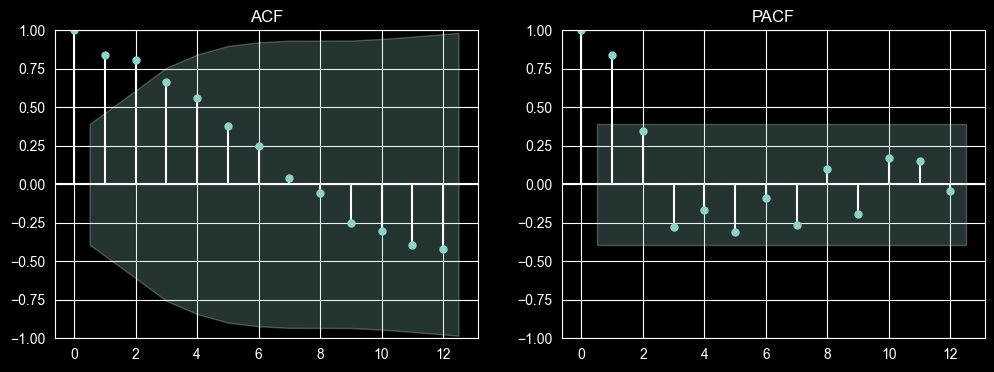

In [210]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,4))

plot_acf(serie, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(serie, ax=axes[1], method="ywm")
axes[1].set_title("PACF")

plt.show()


Lecture de l’ACF (à gauche)

les autocorrélations restent faibles

la majorité des barres est dans l’intervalle de confiance

Lecture de la PACF (à droite)

Pas de structure AR claire
Pas de modèle AR(p) dominant

Les fonctions d’autocorrélation et d’autocorrélation partielle ne révèlent pas de structure AR ou MA marquée, suggérant que la série peut être assimilée à un bruit blanc stationnaire ou modélisée par un ARIMA de faible ordr

AR = AutoRegressive  Yt​=c+ϕ1​Yt−1​+ϕ2​Yt−2​+⋯+ϕp​Yt−p​+εt​
MA = Moving Average  Yt​=μ+εt​+θ1​εt−1​+⋯+θq​εt−q​


Un modèle AR capture la dépendance entre les observations passées, tandis qu’un modèle MA modélise l’impact des chocs aléatoires passés sur la série.

In [211]:
from statsmodels.tsa.arima.model import ARIMA

model_000 = ARIMA(serie, order=(0,0,0))
result_000 = model_000.fit()

print(result_000.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                   25
Model:                          ARIMA   Log Likelihood                -187.266
Date:                Thu, 12 Feb 2026   AIC                            378.531
Time:                        15:20:56   BIC                            380.969
Sample:                    03-31-2000   HQIC                           379.208
                         - 03-31-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7235.4801     90.931     79.571      0.000    7057.258    7413.702
sigma2      1.877e+05   9.66e+04      1.944      0.052   -1502.002    3.77e+05
Ljung-Box (L1) (Q):                  19.95   Jarque-

In [212]:
# ARIMA(1,0,0) (petit effet AR)
model_100 = ARIMA(serie, order=(1,0,0))
result_100 = model_100.fit()

print(result_100.summary())


                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                   25
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -171.019
Date:                Thu, 12 Feb 2026   AIC                            348.038
Time:                        15:20:56   BIC                            351.695
Sample:                    03-31-2000   HQIC                           349.052
                         - 03-31-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7197.6199    318.692     22.585      0.000    6572.996    7822.244
ar.L1          0.8478      0.129      6.553      0.000       0.594       1.101
sigma2      4.868e+04   1.09e+04      4.454      0.0

In [213]:
# ARIMA(0,0,1) (petit effet MA)
model_001 = ARIMA(serie, order=(0,0,1))
result_001 = model_001.fit()

print(result_001.summary())


                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                   25
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -180.879
Date:                Thu, 12 Feb 2026   AIC                            367.759
Time:                        15:20:56   BIC                            371.415
Sample:                    03-31-2000   HQIC                           368.773
                         - 03-31-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7234.2566    110.150     65.676      0.000    7018.366    7450.147
ma.L1          0.5177      0.220      2.358      0.018       0.087       0.948
sigma2      1.113e+05   4.27e+04      2.607      0.0

Le modèle ARIMA(0,0,1) présente un bon ajustement, avec un paramètre MA significatif et des résidus assimilables à un bruit blanc selon le test de Ljung-Box. Il constitue un modèle adéquat pour cette série.

In [214]:
# Comparaison des  models 

print("ARIMA(0,0,0) AIC :", result_000.aic)
print("ARIMA(1,0,0) AIC :", result_100.aic)
print("ARIMA(0,0,1) AIC :", result_001.aic)


ARIMA(0,0,0) AIC : 378.53145487795706
ARIMA(1,0,0) AIC : 348.0378972665853
ARIMA(0,0,1) AIC : 367.7586714165567


Plusieurs modèles ARIMA de faible ordre ont été estimés. Le modèle retenu est celui minimisant le critère AIC, indiquant un compromis optimal entre qualité d’ajustement et complexité.

ConversionError: Failed to convert value(s) to axis units: (datetime.date(1970, 1, 1), datetime.date(1970, 1, 2))

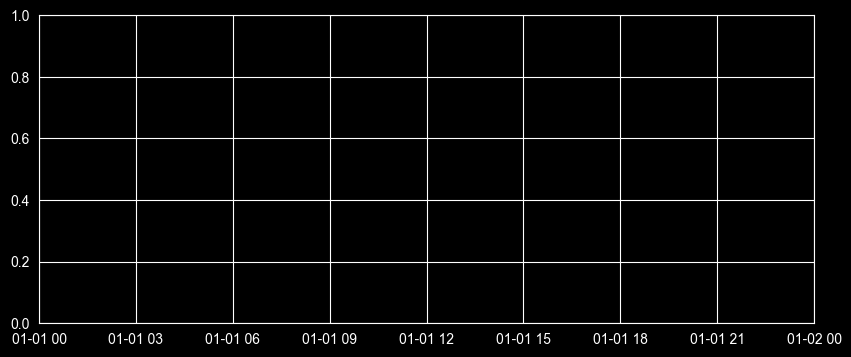

In [215]:
residuals = result_000.resid

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Résidus du modèle")
plt.grid(True)
plt.show()

plot_acf(residuals)
plt.show()


## 5- Stabilité des cycles saisonniers

C:\Users\Abdallah Toumji\AppData\Local\Temp\ipykernel_11608\2348974061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_quarterly['Quarter_Cycle'] = (first_quarterly['TIME'] - 1) % 4 + 1


<Axes: title={'center': 'VALUE'}, xlabel='Quarter_Cycle'>

<Figure size 1000x600 with 0 Axes>

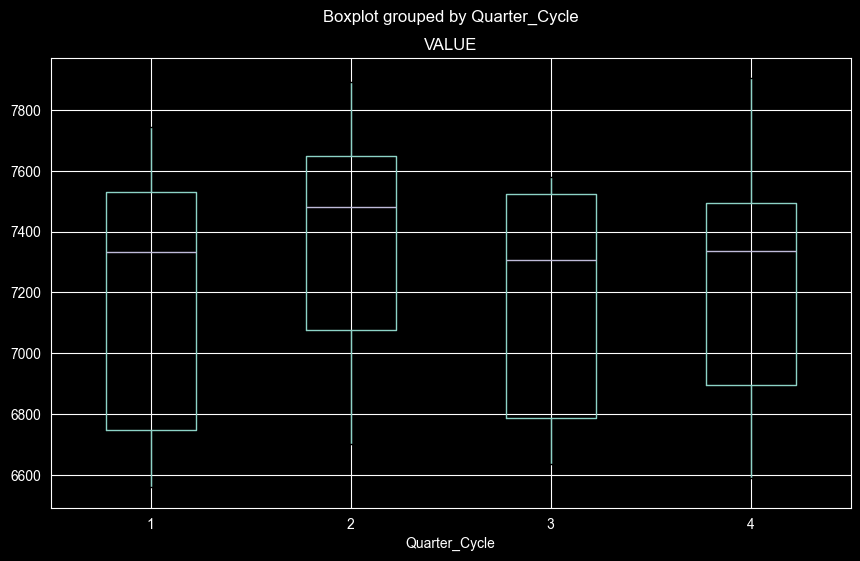

In [221]:
first_quarterly['Quarter_Cycle'] = (first_quarterly['TIME'] - 1) % 4 + 1
plt.figure(figsize=(10, 6))

first_quarterly.boxplot(column='VALUE', by='Quarter_Cycle', figsize=(10, 6))